# Meta-Eval Summariser

Interactive notebook version of `summarise_meta_eval.py`. Use this to explore one or many `_meta_eval.json` files without leaving Jupyter.

In [140]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Set, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
def parse_meta_file_args(items: List[str]) -> List[Tuple[Optional[str], Path]]:
    """Parse inputs in optional TAG:PATH format (directories supported)."""
    parsed: List[Tuple[Optional[str], Path]] = []
    for item in items:
        if ":" in item:
            tag, path_str = item.split(":", 1)
        else:
            tag, path_str = None, item
        path = Path(path_str).expanduser().resolve()
        if path.is_dir():
            json_files = sorted(path.glob("*.json"))
            if not json_files:
                raise FileNotFoundError(f"No JSON files under directory '{path}'")
            for file in json_files:
                parsed.append((tag, file))
        else:
            parsed.append((tag, path))
    return parsed


def infer_method_info(path: Path, clustering_methods: List[str], clusters: List[int]) -> Tuple[str, Any]:
    """Infer method name and configuration (cluster count or run type) from filename."""
    name = path.stem
    
    # 1. Check for Rigorous Methods (Shuffle, Stability)
    if "TargetShuffle" in name:
        return "Target Shuffling", "Rigorous"
    if "StabilitySelection" in name:
        return "Stability Selection", "Rigorous"
        
    # 2. Check for PosDrop Clustering Methods
    matches: List[Tuple[str, int]] = []
    for method in clustering_methods:
        idx = name.find(method)
        while idx != -1:
            start = idx + len(method)
            digits = []
            while start < len(name) and name[start].isdigit():
                digits.append(name[start])
                start += 1
            if digits:
                matches.append((method, int("".join(digits))))
            idx = name.find(method, idx + 1)
            
    if matches:
        matches = list(dict.fromkeys(matches))
        if len(matches) > 1:
             pass
        method, cluster = matches[0]
        return method, cluster
        
    # 3. Fallback
    return "Unknown", "Unknown"


def derive_tag_main(
    path: Path,
    method: str,
    config: Any,
    override: Optional[str] = None,
    allowed_tags: Optional[Set[str]] = None,
) -> str:
    if override:
        return override
    stem = path.stem
    if stem.endswith("_meta_eval"):
        stem = stem[:-len("_meta_eval")]
        
    # Try to strip method suffix if present
    if isinstance(config, int):
        token = f"_{method}{config}"
        if stem.endswith(token):
            stem = stem[:-len(token)]
    elif method in ["Target Shuffling", "Stability Selection"]:
        suffix = "_TargetShuffle" if method == "Target Shuffling" else "_StabilitySelection"
        if stem.endswith(suffix):
            stem = stem[:-len(suffix)]
            
    candidate = stem
    if allowed_tags:
        for tag in allowed_tags:
            if candidate == tag or candidate.startswith(tag):
                return tag
        return candidate
    return candidate


def filter_metrics(raw_metrics: Dict[str, object], selected: List[str]) -> Dict[str, object]:
    if not selected:
        return raw_metrics
    return {metric: raw_metrics[metric] for metric in selected if metric in raw_metrics}


def load_and_summarise(
    meta_files: List[str],
    *,
    clustering_methods: List[str] = ["latent_dist", "actual_dist", "random", "kmeans", "hierarchical"],
    cluster_counts: List[int] = [],
    metrics: Optional[List[str]] = None,
    allowed_tags: Optional[List[str]] = None,
    meta_eval_methods: Optional[List[str]] = None,
) -> Dict[str, Dict[str, Dict[str, Any]]]:
    entries_raw = parse_meta_file_args(meta_files)
    entries = [
        (tag_override, path)
        for tag_override, path in entries_raw
        if path.name != "meta_eval_summary.json"
    ]
    # Normalize metrics to lowercase if provided
    metrics_to_keep = [m.lower() for m in (metrics or [])]
    allowed_set = set(allowed_tags) if allowed_tags else None
    
    # Normalize meta_eval_methods
    if meta_eval_methods:
        requested_methods = set(m.lower() for m in meta_eval_methods)
    else:
        # Default to all if not specified
        requested_methods = {"posdrop", "shuffle", "stability"}

    summary: Dict[str, Dict[str, Dict[str, Any]]] = {}
    
    for tag_override, path in entries:
        if not path.exists():
            print(f"Warning: File not found: {path}")
            continue
            
        with path.open("r", encoding="utf-8") as handle:
            data = json.load(handle)
            
        # 1. Check for Aggregated Results (Target Shuffling / Stability Selection)
        # These are stored in keys 'target_shuffling' and 'stability_selection' in the base file
        aggregated_found = False
        
        if "target_shuffling" in data and "shuffle" in requested_methods:
            aggregated_found = True
            # data['target_shuffling'] is dict of {config: metrics}
            for config_name, metrics_dict in data["target_shuffling"].items():
                # Clean metrics if needed, but usually we want all from aggregated
                # If metrics_to_keep is set, we might filter, but aggregated structure is complex (nested dicts)
                # So we keep it as is or do shallow filter
                cleaned_agg = metrics_dict # Keep full structure for now to support nested keys like pauc.real
                
                tag_main = derive_tag_main(path, "Target Shuffling", config_name, override=tag_override, allowed_tags=allowed_set)
                summary.setdefault(tag_main, {}).setdefault("Target Shuffling", {})[config_name] = cleaned_agg
                
        if "stability_selection" in data and "stability" in requested_methods:
            aggregated_found = True
            for config_name, metrics_dict in data["stability_selection"].items():
                cleaned_agg = metrics_dict
                tag_main = derive_tag_main(path, "Stability Selection", config_name, override=tag_override, allowed_tags=allowed_set)
                summary.setdefault(tag_main, {}).setdefault("Stability Selection", {})[config_name] = cleaned_agg

        # 2. Standard Processing (Individual Files or Base File Metrics)
        # If we found aggregated data, we might still want to process the base metrics (PosDrop)
        # But only if 'posdrop' is requested.
        
        if "posdrop" in requested_methods:
            method, config = infer_method_info(path, clustering_methods, cluster_counts)
            
            # Robust inference fallback
            if method == "Unknown":
                # If it's the base file (no method in name), it might contain top-level metrics which are usually ignored
                # or it might be a specific run file that wasn't caught.
                if 'z_score' in data and data['z_score'] is not None:
                     method, config = "Target Shuffling", "Rigorous"
                elif 'spatial_jaccard' in data and data['spatial_jaccard'] is not None:
                     method, config = "Stability Selection", "Rigorous"
            
            # Filter based on meta_eval_methods for individual files
            is_shuffle = method == "Target Shuffling"
            is_stability = method == "Stability Selection"
            is_posdrop = not (is_shuffle or is_stability or method == "Unknown")
            
            keep = False
            if is_shuffle and "shuffle" in requested_methods:
                keep = True
            elif is_stability and "stability" in requested_methods:
                keep = True
            elif is_posdrop and "posdrop" in requested_methods:
                keep = True
                
            if keep:
                cleaned = filter_metrics(data, metrics_to_keep)
                # Only add if not empty and not just nulls (optional optimization)
                tag_main = derive_tag_main(path, method, config, override=tag_override, allowed_tags=allowed_set)
                summary.setdefault(tag_main, {}).setdefault(method, {})[str(config)] = cleaned
        
    return summary

def plot_posdrop_curves(summary, metric='accuracy'):
    """Plot PosDrop metrics vs Number of Clusters."""
    data_rows = []
    for tag, methods in summary.items():
        for method, configs in methods.items():
            if method in ["Target Shuffling", "Stability Selection"]:
                continue
            for k, metrics in configs.items():
                if metric in metrics and metrics[metric] is not None:
                    val = metrics[metric]
                    if isinstance(val, dict): val = val.get('mean', 0)
                    data_rows.append({'Tag': tag, 'Method': method, 'Clusters': int(k), metric: val})
    
    if not data_rows:
        print(f"No data found for metric: {metric}")
        return
        
    df = pd.DataFrame(data_rows)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Clusters', y=metric, hue='Tag', style='Method', markers=True)
    plt.title(f'{metric} vs Clusters')
    plt.grid(True)
    plt.show()

def display_rigorous_table(summary, method_type="Target Shuffling"):
    """Display table for rigorous methods."""
    rows = []
    for tag, methods in summary.items():
        if method_type in methods:
            metrics = methods[method_type].get("Rigorous", {})
            row = {'Tag': tag}
            for k, v in metrics.items():
                if v is None: continue
                if isinstance(v, dict):
                    if 'real' in v: row[f'{k} (Real)'] = v['real']
                    if 'shuffle_mean' in v: row[f'{k} (Mean)'] = v['shuffle_mean']
                    if 'mean' in v: row[k] = v['mean']
                else:
                    row[k] = v
            rows.append(row)
            
    if rows:
        df = pd.DataFrame(rows)
        print(f"--- {method_type} Results ---")
        display(df)
    else:
        print(f"No results for {method_type}")


In [142]:
def format_metric_value(val, decimals=4):
    if val is None:
        return None
    if isinstance(val, (int, float)):
        return f"{val:.{decimals}f}"
    if isinstance(val, dict):
        if 'mean' in val:
            mean_val = val['mean']
            if isinstance(mean_val, (int, float)):
                std_str = ""
                if 'std' in val and isinstance(val['std'], (int, float)):
                    std_str = f" ± {val['std']:.{decimals}f}"
                return f"{mean_val:.{decimals}f}{std_str}"
            elif isinstance(mean_val, list):
                return "Curve (List)"
    if isinstance(val, list):
        return "Curve (List)"
    return str(val)

def display_rigorous_target_shuffle(summary):
    rows = []
    for tag, methods in summary.items():
        if "Target Shuffling" in methods:
            shuffling_data = methods["Target Shuffling"]
            if "Rigorous" in shuffling_data:
                configs = {"Rigorous": shuffling_data["Rigorous"]}
            else:
                configs = shuffling_data
                
            for config_name, metrics in configs.items():
                row = {'Tag': tag, 'Config': config_name}
                
                # Primary KPIs
                row['Z-Score'] = format_metric_value(metrics.get('z_score'))
                row['FDE'] = format_metric_value(metrics.get('fde'))
                row['Lift'] = format_metric_value(metrics.get('lift'), 2)
                
                pauc = metrics.get('pauc')
                if isinstance(pauc, dict):
                    row['PAUC (Real)'] = format_metric_value(pauc.get('real'))
                    if 'shuffle_mean' in pauc:
                         row['PAUC (Shuffle)'] = f"{format_metric_value(pauc.get('shuffle_mean'))} ± {format_metric_value(pauc.get('shuffle_std'))}"
                    elif 'mean' in pauc:
                         row['PAUC (Shuffle)'] = format_metric_value(pauc)
                else:
                    row['PAUC (Real)'] = format_metric_value(pauc)

                row['Background Rejection'] = format_metric_value(metrics.get('background_rejection'))
                
                # Secondary Diagnostics
                row['Spatial Entropy'] = format_metric_value(metrics.get('spatial_entropy'))
                row['Focus'] = format_metric_value(metrics.get('focus'))
                row['PosDrop Accuracy'] = format_metric_value(metrics.get('posdrop_acc'))
                if 'accuracy' in metrics: # Sometimes called accuracy
                    row['PosDrop Accuracy'] = format_metric_value(metrics.get('accuracy'))
                
                rows.append(row)

    if rows:
        df = pd.DataFrame(rows)
        cols = ['Tag', 'Config', 'Z-Score', 'FDE', 'Lift', 'PAUC (Real)', 'PAUC (Shuffle)', 'Background Rejection', 'Spatial Entropy', 'Focus', 'PosDrop Accuracy']
        cols = [c for c in cols if c in df.columns]
        print("--- Method 1: Target Shuffling Results ---")
        print("Goal: Checking for Hallucination (Significance)")
        print("✅ Primary KPIs: Z-Score, FDE, Lift/PAUC, Background Rejection")
        print("⚠️ Secondary Diagnostics: Spatial Entropy, Focus, PosDrop_Acc")
        display(df[cols])
    else:
        print("No Target Shuffling data found.")

def display_rigorous_stability_selection(summary):
    rows = []
    for tag, methods in summary.items():
        if "Stability Selection" in methods:
            stability_data = methods["Stability Selection"]
            if "Rigorous" in stability_data:
                configs = {"Rigorous": stability_data["Rigorous"]}
            else:
                configs = stability_data
                
            for config_name, metrics in configs.items():
                row = {'Tag': tag, 'Config': config_name}
                
                # Primary KPIs
                row['Spatial Jaccard'] = format_metric_value(metrics.get('spatial_jaccard'))
                row['Spatial Entropy'] = format_metric_value(metrics.get('spatial_entropy'))
                row['Background Rejection'] = format_metric_value(metrics.get('background_rejection'))
                
                # Secondary Diagnostics
                row['Lift'] = format_metric_value(metrics.get('lift'), 2)
                
                pauc = metrics.get('pauc')
                if isinstance(pauc, dict) and 'mean' in pauc:
                     row['PAUC'] = format_metric_value(pauc)
                else:
                     row['PAUC'] = format_metric_value(pauc)

                row['Focus'] = format_metric_value(metrics.get('focus'))
                row['PosDrop Accuracy'] = format_metric_value(metrics.get('posdrop_acc'))
                if 'accuracy' in metrics:
                    row['PosDrop Accuracy'] = format_metric_value(metrics.get('accuracy'))
                
                rows.append(row)

    if rows:
        df = pd.DataFrame(rows)
        cols = ['Tag', 'Config', 'Spatial Jaccard', 'Spatial Entropy', 'Background Rejection', 'Lift', 'PAUC', 'Focus', 'PosDrop Accuracy']
        cols = [c for c in cols if c in df.columns]
        print("--- Method 2: Stability Selection Results ---")
        print("Goal: Checking for Noise Bias (Robustness)")
        print("✅ Primary KPIs: Spatial Jaccard, Spatial Entropy, Background Rejection")
        print("⚠️ Secondary Diagnostics: Lift/PAUC, Focus, PosDrop_Acc")
        display(df[cols])
    else:
        print("No Stability Selection data found.")

def display_posdrop_table(summary):
    rows = []
    for tag, methods in summary.items():
        for method, configs in methods.items():
            if method in ["Target Shuffling", "Stability Selection"]:
                continue
            for config_name, metrics in configs.items():
                row = {'Tag': tag, 'Method': method, 'Clusters': config_name}
                
                # Primary KPIs
                row['PosDrop Accuracy'] = format_metric_value(metrics.get('accuracy'))
                
                # Top-K (Area 1.0%)
                topk = metrics.get('topk')
                if topk and 'area_percentages' in topk:
                    area_1pct = topk['area_percentages'].get('area_1.0pct')
                    if area_1pct:
                        row['Top-k (1%) Capture'] = format_metric_value(area_1pct.get('mean_capture_rate'))
                
                row['Focus'] = format_metric_value(metrics.get('focus'))
                
                # Secondary Diagnostics
                row['Lift'] = None
                lift_data = metrics.get('lift')
                if lift_data and 'area_1.0pct' in lift_data:
                     row['Lift'] = format_metric_value(lift_data['area_1.0pct'].get('mean_lift'), 2)
                elif topk and 'area_percentages' in topk:
                     area_1pct = topk['area_percentages'].get('area_1.0pct')
                     if area_1pct:
                         row['Lift'] = format_metric_value(area_1pct.get('mean_lift'), 2)

                pauc = metrics.get('pauc')
                if isinstance(pauc, dict) and 'mean' in pauc:
                     row['PAUC'] = format_metric_value(pauc)
                elif isinstance(pauc, dict) and 'prior_0.050' in pauc:
                     row['PAUC'] = format_metric_value(pauc['prior_0.050'])
                else:
                     row['PAUC'] = format_metric_value(pauc)

                row['Background Rejection'] = format_metric_value(metrics.get('background_rejection'))
                
                rows.append(row)

    if rows:
        df = pd.DataFrame(rows)
        cols = ['Tag', 'Method', 'Clusters', 'PosDrop Accuracy', 'Top-k (1%) Capture', 'Focus', 'Lift', 'PAUC', 'Background Rejection']
        cols = [c for c in cols if c in df.columns]
        print("--- Method 3: Positive Dropout Results ---")
        print("Goal: Checking for Discovery (Generalization)")
        print("✅ Primary KPIs: PosDrop_Acc, Top-k, Focus")
        print("⚠️ Secondary Diagnostics: Lift/PAUC, Background Rejection")
        display(df[cols])
    else:
        print("No PosDrop data found.")


In [120]:
# Example placeholder arguments.
# Replace strings below with real directories or TAG:PATH pairs.
meta_inputs = [
    "/home/qubuntu25/Desktop/Research/Data/1_Foundation_MVT_Result/2_UFM_v2/TransAggDCCA_Ex1_dim256/cls_1_training_results/meta_evaluation_results",  # directory (all *.json will be processed)
]

# Use the new load_and_summarise function which handles everything
summary = load_and_summarise(
    meta_files=meta_inputs,
    # Ensure all methods are included
    clustering_methods=["random", "kmeans", "hierarchical", "latent_dist", "actual_dist"],
    cluster_counts=[2, 3, 4, 5, 6, 7, 8, 10],
    metrics=["accuracy", "focus", "topk", "lift", "pauc", "background_rejection", "pu_tpr", "spatial_entropy", "spatial_jaccard", "z_score", "fde"],
    allowed_tags=["base_MAEViT_BC"],
)

print(f"Loaded summary for {len(summary)} tags")
summary

Loaded summary for 1 tags


{'base_MAEViT_BC': {'actual_dist': {'10': {'accuracy': {'scores': [0.9953160881996155,
      0.9728661179542542,
      0.9595916271209717,
      0.9305046796798706,
      0.9998111128807068,
      0.9996554851531982,
      0.8707767128944397,
      0.9968581199645996,
      0.999735951423645,
      0.9895666837692261],
     'mean': 0.9714682579040528,
     'std': 0.03987182862376159,
     'scores_info': {'count': 10,
      'description': 'Per-iteration metric values (one entry per positive-drop fold).'}},
    'focus': None,
    'topk': {'area_percentages': {'area_0.1pct': {'capture_rates': [0.25,
        0.35,
        0.35,
        0.19047619047619047,
        0.23809523809523808,
        0.23809523809523808,
        0.19047619047619047,
        0.14285714285714285,
        0.19047619047619047,
        0.19047619047619047],
       'precisions': [0.010752688172043012,
        0.015053763440860216,
        0.015053763440860216,
        0.008602150537634409,
        0.010752688172043012,


## Example usage

Fill in the paths/tags that match your run and execute the next cell.

In [121]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scalar_metric(summary_dict, metric_name='accuracy',
                       include_tags=None, include_methods=None, include_clusters=None):
    # Normalize metric name to lowercase to handle 'Focus' vs 'focus'
    metric_name = metric_name.lower()
    
    include_tags = set(include_tags) if include_tags else None
    include_methods = set(include_methods) if include_methods else None
    include_clusters = set(int(c) for c in include_clusters) if include_clusters else None

    rows = []
    for tag_main, methods_dict in summary_dict.items():
        if include_tags and tag_main not in include_tags:
            continue
        for method, clusters_dict in methods_dict.items():
            if include_methods and method not in include_methods:
                continue
            for cluster, metrics in clusters_dict.items():
                cluster_id = int(cluster)
                if include_clusters and cluster_id not in include_clusters:
                    continue
                # Try exact match or lowercase match
                metric = metrics.get(metric_name)
                if isinstance(metric, dict) and isinstance(metric.get('mean'), (int, float)):
                    rows.append((tag_main, method, cluster_id, float(metric['mean'])))
                elif isinstance(metric, (int, float)):
                    rows.append((tag_main, method, cluster_id, float(metric)))
                    
    if not rows:
        print(f"Warning: No scalar '{metric_name}' values found after filtering.")
        return

    palettes = {
        'base_MAEViT_BC': plt.cm.Blues,
        'Method2_concat_MAEViT_plus_TransDCCA_BC': plt.cm.Reds,
    }
    default_cmap = plt.cm.Greys

    plt.figure(figsize=(8, 5))
    for tag in sorted({r[0] for r in rows}):
        tag_rows = [r for r in rows if r[0] == tag]
        tag_rows.sort(key=lambda x: x[2])
        clusters = [r[2] for r in tag_rows]
        values = [r[3] for r in tag_rows]
        cmap = palettes.get(tag, default_cmap)(np.linspace(0.3, 0.9, len(tag_rows)))
        plt.plot(clusters, values, marker='o', color=cmap[-1], label=tag)

    plt.xlabel('Cluster Count')
    plt.ylabel(f'{metric_name} mean')
    plt.title(f'{metric_name} across cluster counts by tag')
    handles, _ = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [122]:
# Example:
plot_scalar_metric(summary, metric_name='Focus', include_methods=['kmeans'])

In [123]:
# Example:
plot_scalar_metric(summary, metric_name='Focus', include_methods=['kmeans'])

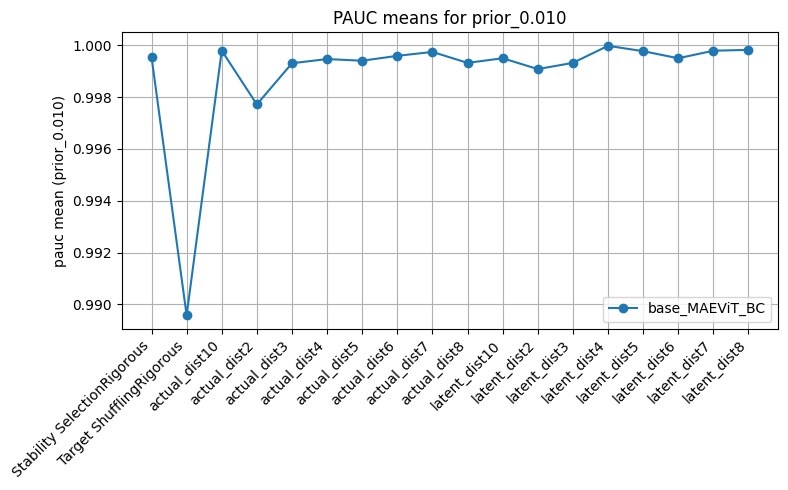

In [124]:
import matplotlib.pyplot as plt

def plot_pauc(summary_dict, prior_key='prior_0.010'):
    by_tag = {}
    for tag_main, methods_dict in summary_dict.items():
        entries = []
        for method, clusters_dict in methods_dict.items():
            for cluster, metrics in clusters_dict.items():
                entry = metrics.get('pauc', {}).get(prior_key)
                if isinstance(entry, dict) and isinstance(entry.get('mean'), (int, float)):
                    entries.append((f'{method}{cluster}', float(entry['mean'])))
        if entries:
            by_tag[tag_main] = entries
    if not by_tag:
        raise RuntimeError(f'No PAUC data found for {prior_key}.')
    plt.figure(figsize=(8, 5))
    for tag, entries in by_tag.items():
        entries.sort(key=lambda x: x[0])
        labels = [label for label, _ in entries]
        values = [val for _, val in entries]
        plt.plot(labels, values, marker='o', label=tag)
    plt.ylabel(f'pauc mean ({prior_key})')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'PAUC means for {prior_key}')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pauc(summary, prior_key='prior_0.010')


In [125]:
import matplotlib.pyplot as plt

def plot_topk_metric(summary_dict, ratio_keys=None, metric='mean_capture_rate', include_methods=None):
    include_methods = set(include_methods) if include_methods else None

    if ratio_keys is None:
        first_tag = next(iter(summary_dict.values()))
        first_method = next(iter(first_tag.values()))
        first_clusters = next(iter(first_method.values()))
        ratio_keys = sorted(first_clusters.get('topk', {}).get('ratios', {}).keys())
    if not ratio_keys:
        raise RuntimeError('No ratio keys available in summary.')

    plt.figure(figsize=(8, 5))
    for ratio_key in ratio_keys:
        entries = []
        for tag_main, methods in summary_dict.items():
            for method, clusters_dict in methods.items():
                if include_methods and method not in include_methods:
                    continue
                for cluster, metrics in clusters_dict.items():
                    ratio_entry = metrics.get('topk', {}).get('ratios', {}).get(ratio_key)
                    if isinstance(ratio_entry, dict) and isinstance(ratio_entry.get(metric), (int, float)):
                        entries.append((tag_main, int(cluster), float(ratio_entry[metric])))
        if entries:
            entries.sort(key=lambda x: (x[0], x[1]))
            tags = sorted(set(tag for tag, _, _ in entries))
            for tag in tags:
                tag_entries = [entry for entry in entries if entry[0] == tag]
                clusters = [entry[1] for entry in tag_entries]
                values = [entry[2] for entry in tag_entries]
                plt.plot(clusters, values, marker='o', label=f"{tag} {ratio_key}")

    plt.xlabel('Cluster Count')
    plt.ylabel(metric)
    plt.title('TopK ratios vs cluster count')
    handles, _ = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


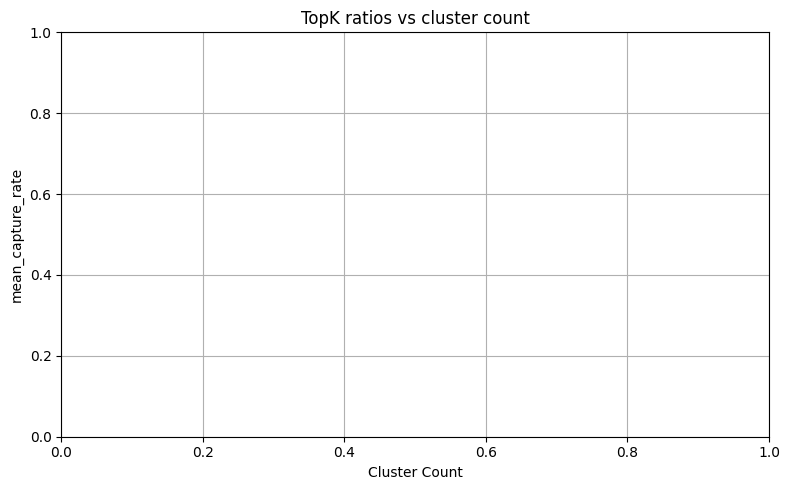

In [126]:
plot_topk_metric(summary,
                 ratio_keys=['ratio_0.50','ratio_1.00'],
                 metric='mean_capture_rate',
                 include_methods=['kmeans'])

In [ ]:
def plot_topk_absolute(summary_dict, k_keys=None, metric='mean_capture_rate'):
    """Plot absolute Top-K metrics."""
    if k_keys is None:
        k_keys = ['k_10', 'k_50', 'k_100', 'k_200']
        
    entries = []
    for tag_main, methods in summary_dict.items():
        for method, clusters_dict in methods.items():
            for cluster, metrics in clusters_dict.items():
                # Robust access to topk -> absolute
                topk_data = metrics.get('topk')
                if not isinstance(topk_data, dict):
                    continue
                    
                absolute_data = topk_data.get('absolute')
                if not isinstance(absolute_data, dict):
                    continue
                    
                for k_key in k_keys:
                    abs_entry = absolute_data.get(k_key)
                    if isinstance(abs_entry, dict) and isinstance(abs_entry.get(metric), (int, float)):
                        entries.append((tag_main, int(cluster), float(abs_entry[metric]), k_key))
                        
    if not entries:
        print(f"No absolute Top-K data found for keys {k_keys} and metric {metric}.")
        return
        
    df = pd.DataFrame(entries, columns=['Tag', 'Clusters', metric, 'K'])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Clusters', y=metric, hue='Tag', style='K', markers=True)
    plt.title(f'Absolute Top-K {metric}')
    plt.grid(True)
    plt.show()

In [128]:
import matplotlib.pyplot as plt

def plot_topk_area(summary_dict, area_keys=None, metric='mean_capture_rate', include_methods=None):
    if area_keys is None:
        first_tag = next(iter(summary_dict.values()))
        first_method = next(iter(first_tag.values()))
        first_clusters = next(iter(first_method.values()))
        area_keys = sorted(first_clusters.get('topk', {}).get('area_percentages', {}).keys())
    if not area_keys:
        raise RuntimeError('No area percentage keys available in summary.')
    plt.figure(figsize=(8, 5))
    for area_key in area_keys:
        entries = []
        for tag_main, methods in summary_dict.items():
            for method, clusters_dict in methods.items():
                if include_methods and method not in include_methods:
                    continue
                for cluster, metrics in clusters_dict.items():
                    area_entry = metrics.get('topk', {}).get('area_percentages', {}).get(area_key)
                    if isinstance(area_entry, dict) and isinstance(area_entry.get(metric), (int, float)):
                        entries.append((tag_main, method, int(cluster), float(area_entry[metric])))
        if entries:
            entries.sort(key=lambda x: (x[0], x[2]))
            tags = sorted(set(entry[0] for entry in entries))
            for tag in tags:
                tag_entries = [entry for entry in entries if entry[0] == tag]
                clusters = [entry[2] for entry in tag_entries]
                values = [entry[3] for entry in tag_entries]
                methods_present = sorted(set(entry[1] for entry in tag_entries))
                label = f"{tag} {area_key}"
                if methods_present:
                    label = f"{tag} ({','.join(methods_present)}) {area_key}"
                plt.plot(clusters, values, marker='o', label=label)
    plt.xlabel('Cluster Count')
    plt.ylabel(metric)
    plt.title('TopK area percentages vs cluster count')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

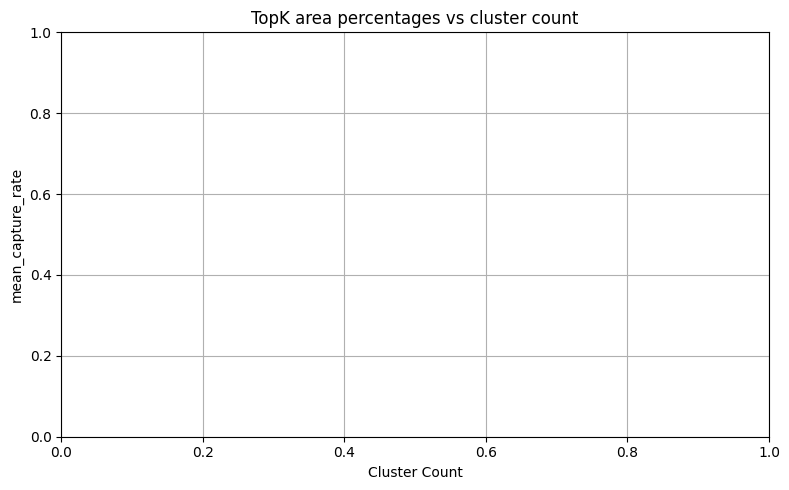

In [129]:
plot_topk_area(summary, area_keys=['area_0.1pct', 'area_0.5pct', 'area_1.0pct', 'area_2.0pct'], metric='mean_capture_rate', include_methods=['kmeans'])

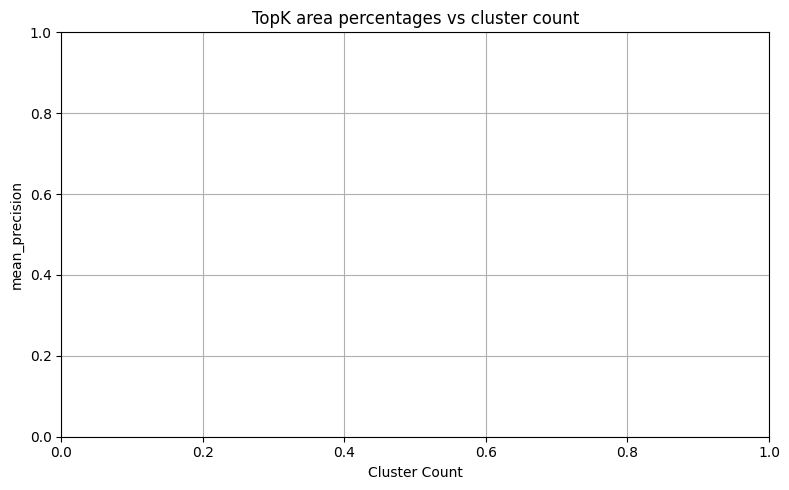

In [130]:
plot_topk_area(summary, area_keys=['area_0.1pct', 'area_0.5pct', 'area_1.0pct', 'area_10.0pct'], metric='mean_precision', include_methods=['kmeans'])

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pu_curve(
    summary_dict,
    metric_name="pu_fpr",
    include_tags=None,
    include_methods=None,
    include_clusters=None,
):
    include_tags = set(include_tags) if include_tags else None
    include_methods = set(include_methods) if include_methods else None
    include_clusters = set(int(c) for c in include_clusters) if include_clusters else None

    tag_palettes = {
        "base_MAEViT_BC": plt.cm.Blues,
        "Method2_concat_MAEViT_plus_TransDCCA_BC": plt.cm.Reds,
    }
    default_cmap = plt.cm.Greys

    aggregated_curves = []
    for tag, methods in summary_dict.items():
        if include_tags and tag not in include_tags:
            continue
        # count clusters for this tag to size the colormap
        total_clusters = sum(len(clusters) for clusters in methods.values())
        cmap = tag_palettes.get(tag, default_cmap)(np.linspace(0.3, 0.9, max(1, total_clusters)))
        cmap_iter = iter(cmap)

        for method, clusters in methods.items():
            if include_methods and method not in include_methods:
                continue
            for cluster, metrics in clusters.items():
                cluster_id = int(cluster)
                if include_clusters and cluster_id not in include_clusters:
                    continue
                block = metrics.get(metric_name)
                if not block:
                    continue
                color = next(cmap_iter, cmap[-1])
                aggregated_curves.append((tag, method, cluster_id, block, color))

    if not aggregated_curves:
        raise RuntimeError("No matching PU curves found for the specified filters.")

    plt.figure(figsize=(9, 5))
    for tag, method, cluster_id, block, color in aggregated_curves:
        thresholds = block["thresholds"]
        base_label = f"{tag} {method}{cluster_id}"
        if metric_name == "background_rejection":
            mean, std = block["mean"], block["std"]
            plt.plot(thresholds, mean, color=color, label=base_label)
            plt.fill_between(
                thresholds,
                [m - s for m, s in zip(mean, std)],
                [m + s for m, s in zip(mean, std)],
                color=color,
                alpha=0.15,
            )
        else:
            for entry in block.get("pi_stats", []):
                pi = entry["pi"]
                mean, std = entry["mean"], entry["std"]
                plt.plot(thresholds, mean, color=color, label=f"{base_label} π={pi}")
                plt.fill_between(
                    thresholds,
                    [m - s for m, s in zip(mean, std)],
                    [m + s for m, s in zip(mean, std)],
                    color=color,
                    alpha=0.12,
                )

    plt.xscale("log")
    plt.xlabel("Threshold")
    plt.ylabel(f"{metric_name} mean")
    plt.title(f"{metric_name}: combined view")
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [132]:
# # plot_pu_curve(summary, metric_name="pu_fpr", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
# #               include_methods=["random", "kmeans", "hierarchical"],)

# plot_pu_curve(summary, metric_name="pu_fpr", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
#               include_methods=["kmeans"], include_clusters= [10])

In [133]:
# plot_pu_curve(summary, metric_name="background_rejection", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
#               include_methods=["kmeans"], include_clusters= [2, 10])

In [134]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pu_npv(
    summary_dict,
    include_tags=None,
    include_methods=None,
    include_clusters=None,
    pi_keys=None,
):
    include_tags = set(include_tags) if include_tags else None
    include_methods = set(include_methods) if include_methods else None
    include_clusters = set(int(c) for c in include_clusters) if include_clusters else None

    tag_palettes = {
        "base_MAEViT_BC": plt.cm.Blues,
        "Method2_concat_MAEViT_plus_TransDCCA_BC": plt.cm.Reds,
    }
    default_cmap = plt.cm.Greys

    entries = []
    for tag, methods in summary_dict.items():
        if include_tags and tag not in include_tags:
            continue
        total_clusters = sum(len(clusters) for clusters in methods.values())
        cmap = tag_palettes.get(tag, default_cmap)(np.linspace(0.3, 0.9, max(1, total_clusters)))
        cmap_iter = iter(cmap)

        for method, clusters in methods.items():
            if include_methods and method not in include_methods:
                continue
            for cluster, metrics in clusters.items():
                cluster_id = int(cluster)
                if include_clusters and cluster_id not in include_clusters:
                    continue
                block = metrics.get("pu_npv")
                if not block:
                    continue
                color = next(cmap_iter, cmap[-1])
                entries.append((tag, method, cluster_id, block, color))

    if not entries:
        raise RuntimeError("No pu_npv data found for given filters.")

    plt.figure(figsize=(10, 5))
    for tag, method, cluster_id, block, color in entries:
        npv_block = block.get("npv", {})
        thresholds = npv_block.get("thresholds")
        pi_stats = npv_block.get("pi_stats", [])
        if not thresholds or not pi_stats:
            continue
        active_pis = pi_keys or [entry["pi"] for entry in pi_stats]
        for entry in pi_stats:
            if entry["pi"] not in active_pis:
                continue
            mean = entry["mean"]
            std = entry["std"]
            label = f"{tag} {method}{cluster_id} π={entry['pi']}"
            plt.plot(thresholds, mean, color=color, label=label)
            lower = [m - s for m, s in zip(mean, std)]
            upper = [m + s for m, s in zip(mean, std)]
            plt.fill_between(thresholds, lower, upper, color=color, alpha=0.15)

    plt.xscale("log")
    plt.xlabel("Threshold")
    plt.ylabel("PU-NPV mean")
    plt.title("PU-NPV across tags/methods")
    handles, _ = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [135]:
# plot_pu_npv(
#     summary,
#     include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
#     include_methods=["kmeans"],
#     include_clusters=[10],
#     pi_keys=[0.01, 0.2],
# )

In [136]:
# Load Data
meta_files = [
    # Add your file paths here, e.g.
    # "/path/to/cls_1_training_results/meta_evaluation_results"
]
# Or automatically find them if running in the same dir structure
import os
base_dir = Path("/home/qubuntu25/Desktop/Research/Data/1_Foundation_MVT_Result/2_UFM_v2/TransAggDCCA_Ex1_dim256/cls_1_training_results/meta_evaluation_results/").resolve()
if base_dir.exists():
    meta_files = [str(base_dir)]

summary = load_and_summarise(meta_files)
print(f"Loaded summary for {len(summary)} tags")

Loaded summary for 22 tags


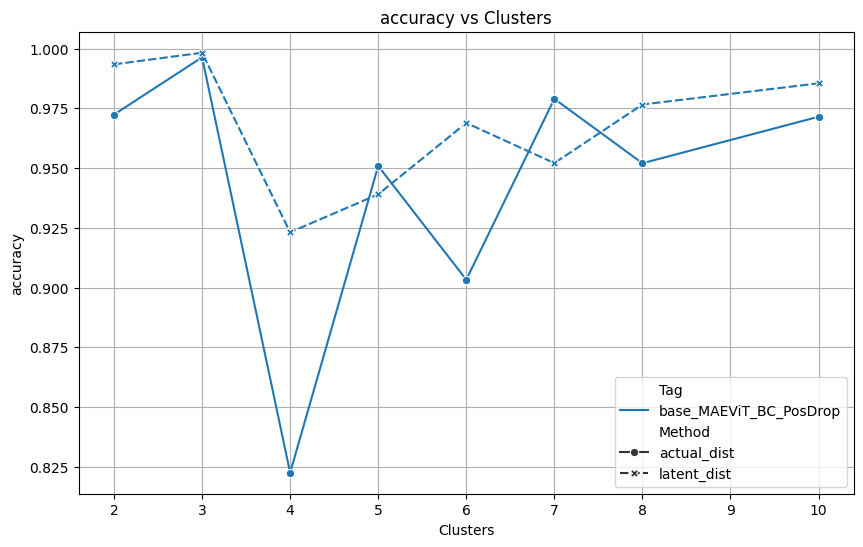

No data found for metric: focus


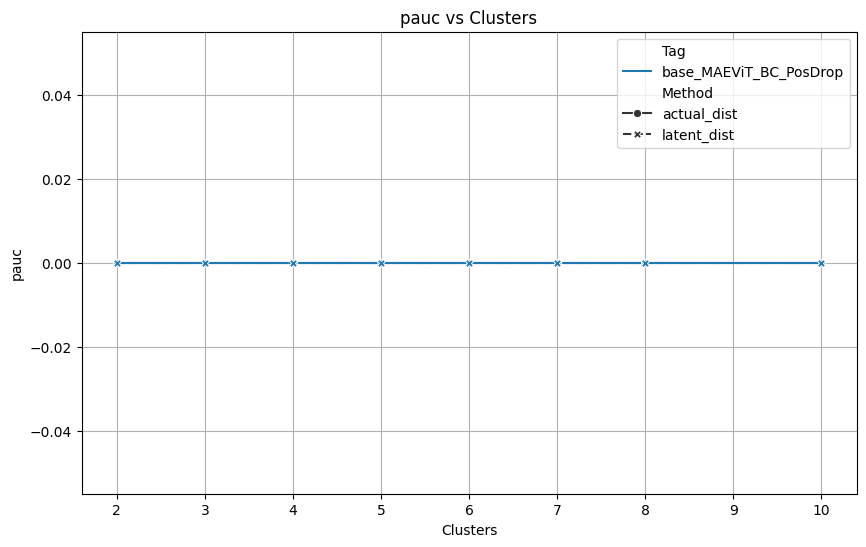

In [137]:
# 1. Plot PosDrop Curves
plot_posdrop_curves(summary, metric='accuracy')
plot_posdrop_curves(summary, metric='focus')
plot_posdrop_curves(summary, metric='pauc')

In [138]:
# Display Rigorous Results
display_rigorous_target_shuffle(summary)

--- Method 1: Target Shuffling Results ---
Goal: Checking for Hallucination (Significance)
✅ Primary KPIs: Z-Score, FDE, Lift/PAUC, Background Rejection
⚠️ Secondary Diagnostics: Spatial Entropy, Focus, PosDrop_Acc


,Tag,Config,Z-Score,FDE,Lift,PAUC (Real),PAUC (Shuffle),Background Rejection,Spatial Entropy,Focus,PosDrop Accuracy
0,base_MAEViT_BC_TargetShuffle_run0,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 130.434782608695...,None,NaN,Curve (List),None,None,None
1,base_MAEViT_BC_TargetShuffle_run1,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 260.869565217391...,None,NaN,Curve (List),None,None,None
2,base_MAEViT_BC_TargetShuffle_run2,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 217.391304347826...,None,NaN,Curve (List),None,None,None
3,base_MAEViT_BC_TargetShuffle_run3,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 86.9565217391304...,None,NaN,Curve (List),None,None,None
4,base_MAEViT_BC_TargetShuffle_run4,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 304.347826086956...,None,NaN,Curve (List),None,None,None
5,base_MAEViT_BC_TargetShuffle_run5,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 130.434782608695...,None,NaN,Curve (List),None,None,None
6,base_MAEViT_BC_TargetShuffle_run6,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 217.391304347826...,None,NaN,Curve (List),None,None,None
7,base_MAEViT_BC_TargetShuffle_run7,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 43.4782608695652...,None,NaN,Curve (List),None,None,None
8,base_MAEViT_BC_TargetShuffle_run8,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 173.913043478260...,None,NaN,Curve (List),None,None,None
9,base_MAEViT_BC_TargetShuffle_run9,Rigorous,None,None,{'area_0.1pct': {'mean_lift': 304.347826086956...,None,NaN,Curve (List),None,None,None


In [139]:
display_rigorous_stability_selection(summary)

--- Method 2: Stability Selection Results ---
Goal: Checking for Noise Bias (Robustness)
✅ Primary KPIs: Spatial Jaccard, Spatial Entropy, Background Rejection
⚠️ Secondary Diagnostics: Lift/PAUC, Focus, PosDrop_Acc


,Tag,Config,Spatial Jaccard,Spatial Entropy,Background Rejection,Lift,PAUC,Focus,PosDrop Accuracy
0,base_MAEViT_BC_StabilitySelection_run0,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 304.347826086956...,{'prior_0.010': {'scores': [0.999955489124136]...,None,None
1,base_MAEViT_BC_StabilitySelection_run1,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 217.391304347826...,{'prior_0.010': {'scores': [0.9999084587647327...,None,None
2,base_MAEViT_BC_StabilitySelection_run2,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 217.391304347826...,{'prior_0.010': {'scores': [0.9999490504439796...,None,None
3,base_MAEViT_BC_StabilitySelection_run3,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 304.347826086956...,{'prior_0.010': {'scores': [0.9998053465680248...,None,None
4,base_MAEViT_BC_StabilitySelection_run4,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 217.391304347826...,{'prior_0.010': {'scores': [0.9999371995399235...,None,None
5,base_MAEViT_BC_StabilitySelection_run5,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 173.913043478260...,{'prior_0.010': {'scores': [0.9997724999678067...,None,None
6,base_MAEViT_BC_StabilitySelection_run6,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 217.391304347826...,{'prior_0.010': {'scores': [0.999894554948163]...,None,None
7,base_MAEViT_BC_StabilitySelection_run7,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 260.869565217391...,{'prior_0.010': {'scores': [0.9998932485492907...,None,None
8,base_MAEViT_BC_StabilitySelection_run8,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 304.347826086956...,{'prior_0.010': {'scores': [0.9998592821786105...,None,None
9,base_MAEViT_BC_StabilitySelection_run9,Rigorous,None,None,Curve (List),{'area_0.1pct': {'mean_lift': 173.913043478260...,{'prior_0.010': {'scores': [0.9995575973533106...,None,None
